In [2]:
import pandas as pd
import numpy as np
import os, sys
import re
import glob, os
# from ckonlpy.tag import Twitter
from konlpy.tag import Kkma, Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from pyclustering.cluster import kmedoids
from collections import Counter
from tqdm import tqdm

In [3]:
BASE_DIR = os.getcwd()
senti = pd.read_csv(BASE_DIR + '/data/ratings.txt', sep='\t')

In [4]:
senti

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [5]:
BASE_DIR

'C:\\Users\\20191\\OneDrive - 경희대학교\\바탕 화면\\cap'

In [6]:
df_test = pd.read_csv(BASE_DIR + '/data/test.txt', sep='\t')
df_train = pd.read_csv(BASE_DIR + '/data/train.txt', sep='\t')

In [7]:
df_train['document'].nunique(), df_train['label'].nunique()
df_train.drop_duplicates(subset=['document'], inplace=True)

In [8]:
df_train = df_train.dropna(how = 'any')

In [9]:
df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_train[:5]

<ipython-input-9-633b4bb115dc>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [10]:
df_train['document'] = df_train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
df_train['document'].replace('', np.nan, inplace=True)

<ipython-input-10-aa27f7866939>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['document'] = df_train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [11]:
df_train.loc[df_train.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [12]:
df_train = df_train.dropna(how = 'any')

In [13]:
df_test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
df_test['document'] = df_test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
df_test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df_test = df_test.dropna(how='any') # Null 값 제거

<ipython-input-13-e5b69bf3bb71>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-13-e5b69bf3bb71>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['document'] = df_test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [14]:
df_train.to_csv(BASE_DIR + '/csv/train.csv', encoding='utf-8-sig', index=False)
df_test.to_csv(BASE_DIR + '/csv/test.csv', encoding='utf-8-sig', index=False)

In [15]:
df_test = pd.read_csv(BASE_DIR + '/csv/test.csv')
df_train = pd.read_csv(BASE_DIR + '/csv/train.csv')

In [16]:
stopwords = pd.read_csv('./data/stopwords.txt').values.tolist()

In [17]:
okt = Okt()

In [18]:
X_train = []
for sentence in tqdm(df_train['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 145393/145393 [08:09<00:00, 296.86it/s]


In [19]:
X_test = []
for sentence in tqdm(df_test['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 48852/48852 [02:59<00:00, 271.96it/s]


In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [21]:
threshold = 10
total_count = len(tokenizer.word_index) # 단어의 수
below_treshhold_count = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
below_treshhold_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq += value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        below_treshhold_count += 1
        below_treshhold_freq += value

print('단어 집합(vocabulary)의 크기 :',total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, below_treshhold_count))
print("단어 집합에서 희귀 단어의 비율:", (below_treshhold_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (below_treshhold_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43770
등장 빈도가 9번 이하인 희귀 단어의 수: 34608
단어 집합에서 희귀 단어의 비율: 79.06785469499657
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.252908861364179


In [22]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_count - below_treshhold_count + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9163


In [23]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
y_train = np.array(df_train['label'])
y_test = np.array(df_train['label'])

In [25]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [26]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

144991
144991


C:\Users\20191\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [27]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [28]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 91.9995034174535


In [29]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [30]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/10
1813/1813 [==============================] - ETA: 0s - loss: 0.4108 - acc: 0.8105
Epoch 1: val_acc improved from -inf to 0.82875, saving model to best_model.h5
1813/1813 [==============================] - 180s 98ms/step - loss: 0.4108 - acc: 0.8105 - val_loss: 0.3972 - val_acc: 0.8288
Epoch 2/10
1813/1813 [==============================] - ETA: 0s - loss: 0.3487 - acc: 0.8463
Epoch 2: val_acc improved from 0.82875 to 0.84393, saving model to best_model.h5
1813/1813 [==============================] - 139s 77ms/step - loss: 0.3487 - acc: 0.8463 - val_loss: 0.3511 - val_acc: 0.8439
Epoch 3/10
1813/1813 [==============================] - ETA: 0s - loss: 0.3244 - acc: 0.8595
Epoch 3: val_acc improved from 0.84393 to 0.84527, saving model to best_model.h5
1813/1813 [==============================] - 143s 79ms/step - loss: 0.3244 - acc: 0.8595 - val_loss: 0.3596 - val_acc: 0.8453
Epoch 4/10
1813/1813 [==============================] - ETA: 0s - loss: 0.3055 - acc: 0.8699
Epoch 4: v

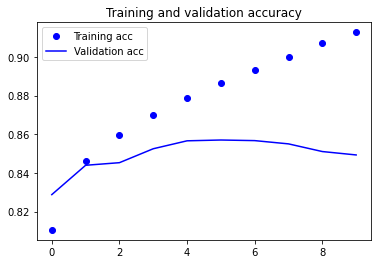

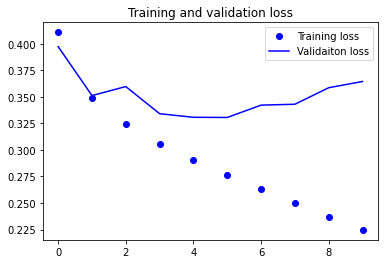

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs = range(len(acc)))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaiton loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        return str(round(score*100, 2)) + '% 긍정'
    else:
        return str(round((1-score)*100, 2)) + '% 부정'